# Introduction
This notebook covers part 2 data analysis of the paper: "3D-printed registration phantom for multiscale ultrasound and optical microscopy of small tissue samples."

This involves three parts.

1.) Rotation: Calculating coordinate system transforms and standard deviations for the fiducial phantom over 5 rotations.

2.) Height: Calculating the coordinate system transforms and standard deviations for the fiducial phantom over 7 heights.

3.) Tendon: Apply the transform onto an image of a tendon.

In [1]:
# Import basic modules
from pathlib import Path
import numpy as np
import SimpleITK as sitk
%matplotlib notebook
import matplotlib.pyplot as plt
import tiffile as tif
import pickle
import os

In [2]:
# These modules all come from the multiscale-imaging package: https://github.com/uw-loci/multiscale
import multiscale.ultrasound.reconstruction as recon
import multiscale.itk.itk_plotting as iplt
import multiscale.itk.registration as reg
import multiscale.itk.process as proc
import multiscale.utility_functions as util

The function definitions below are provided to show the operations applied to acquire the results.  These functions have also been adapted into the multiscale imaging package.  The modified versions are used in the single registration example notebook.

In [3]:
# These function definitions are used for the analysis.

def open_us(us_path, dynamic_range, spacing, origin):
    """Open the US image, window it to a dynamic range, and rotate it to microscope coordinate axes"""
    raw_image = sitk.ReadImage(str(us_path))
    windowed_image = proc.window_image(raw_image, dynamic_range)
    us_image = rotate_axes_to_microscope(windowed_image)
    us_image.SetSpacing(spacing)
    us_image.SetOrigin(origin)
    us_image.SetDirection([1, 0, 0, 0, 1, 0, 0, 0, -1])
    return us_image

def open_mpm(mpm_path, mpm_origin_path, mpm_spacing):
    """Open the MPM image and set the direction to -1 in Z to mirror microscope convention"""
    positions = positions_from_ometif(mpm_origin_path)
    origin = np.min(positions, 0)
    mpm_image = sitk.ReadImage(str(mpm_path))
    mpm_image.SetSpacing(mpm_spacing)
    mpm_image.SetOrigin(origin)
    mpm_image.SetDirection([1, 0, 0, 0, 1, 0, 0, 0, -1])
    return mpm_image

def rotate_axes_to_microscope(image):
    """Rotate the US axes to be along the microscope axes"""
    arr = sitk.GetArrayFromImage(image)
    arr_rot = np.swapaxes(arr, 0, 1)
    arr_rot = np.flip(arr_rot, 0).astype(np.uint8)
    return sitk.GetImageFromArray(arr_rot)

def positions_from_ometif(file_path):
    """Read a .ome.tif file and grab the image positions as a numpy array"""
    reader = sitk.ImageFileReader()
    reader.SetFileName(str(file_path))
    reader.ReadImageInformation()
    raw_info = reader.GetMetaData('ImageDescription')
    info = tif.xml2dict(raw_info)
    mpm_list = []
    for position in info['OME']['Image']:
        x = position['StageLabel']['X']
        y = position['StageLabel']['Y']
        z = position['Pixels']['Plane'][0]['PositionZ']
        mpm_list.append(np.array([x, y, z]))
    return np.array(mpm_list)

def get_xy_origin(pl_path):
    """Read an ultrasound position list and get the XY origin"""
    raw_pos_list = util.read_json(pl_path)
    pos_list = recon.clean_position_text(raw_pos_list)[0]
    xy_origin = np.min(pos_list, 0)
    return xy_origin

def connected_components(us_image):
    """Process the US image using Otsu thresholding and binary opening/closing to get the connected components"""
    thresh_filter = sitk.OtsuThresholdImageFilter()
    thresh_filter.SetInsideValue(0)
    thresh_filter.SetOutsideValue(1)
    thresh_img = thresh_filter.Execute(us_image)
    thresh_value = thresh_filter.GetThreshold()

    print("Threshold used: {}".format(thresh_value))

    cleaned_thresh_img = sitk.BinaryOpeningByReconstruction(thresh_img, [4, 4, 2])
    cleaned_thresh_img = sitk.BinaryClosingByReconstruction(cleaned_thresh_img, [4, 4, 2])

    connected_img = sitk.ConnectedComponent(cleaned_thresh_img)
    return connected_img

def get_fiducial_stats(connected_img):
    """Get statistics for each object in a label image"""
    stats = sitk.LabelShapeStatisticsImageFilter()
    stats.ComputeOrientedBoundingBoxOn()
    stats.ComputePerimeterOn()
    stats.Execute(connected_img)    
    return stats

def filter_labels(stats):
    """Filter labels by property so you only get the fiducial circles"""
    return [l for l in stats.GetLabels() if (stats.GetNumberOfPixels(l) < 300000 
                                             and stats.GetEquivalentEllipsoidDiameter(l)[1] > 2000)]

def get_leveled_centroid(stats, true_labels):
    """Get the leveled Z height, equivalent to the bottom of fiducial, for each label"""
    centroid = [stats.GetCentroid(l) for l in true_labels]
    level_center = []
    idx = 0
    for center in centroid:
        level_center.append(center[2] + np.floor((idx+3)/3)*1000)
        idx = idx+1
    return np.array(level_center)

def apply_transform(moving_image, fixed_image, transform_params):
    """Apply a rigid transform based on input parameters"""
    transform = sitk.VersorRigid3DTransform()
    transform.SetParameters(transform_params)
    reg = sitk.Resample(moving_image, fixed_image, transform, sitk.sitkLinear, 0.0, fixed_image.GetPixelID())
    return reg

def calculate_centroid(image):
    """Take a connected component image and calculate Z height of fiducials"""
    stats = get_fiducial_stats(image)
    labels = filter_labels(stats)
    centroids = get_leveled_centroid(stats, labels)
    return centroids

In [4]:
# The input files are available at https://uwmadison.box.com/s/05ou19dsi2y2wfzgocf1ab7cbbeb4fgn
base_dir = Path(r'F:\Research')

fiducial_dir = Path(base_dir, r'Fiducial paper analysis')
metadata_dir = Path(base_dir, r'Fiducial paper analysis\Metadata images')
mpm_dir = Path(base_dir, r'Fiducial paper analysis\MPM Images\MPM downsampled')
us_dir = Path(base_dir, r'Fiducial paper analysis\Ultrasound')
registered_dir = Path(base_dir, r'Fiducial paper analysis\Registered')

# Transducer height change
This section calculates how changing the transducer height modifies the transform results.  These images were all taken with the phantom in the same location, corresponding to image 0 in the rotation experiment.

In [5]:
# Assign spacing manually
us_spacing = [25, 25, 25]
mpm_spacing = [8.16, 8.16, 25]

# Specify the dynamic range of the US image
dynamic_range = 50

In [6]:
# Open the MPM image of the fiducials
mpm_path = Path(mpm_dir, 'MPM acq 1_8x.tif')
mpm_origin_path = Path(metadata_dir, 'Fiducial acq 1.ome.tif')
mpm_image = open_mpm(mpm_path, mpm_origin_path, mpm_spacing)

In [7]:
# Open the US image taken at height 0
us_pl_path = Path(fiducial_dir, '2019-05-04_US - 3X 100YSep.pos')
us_xy_origin = get_xy_origin(us_pl_path)
us_origin = np.array([us_xy_origin[0], us_xy_origin[1], 0])
us_path = Path(us_dir, 'US Rotation 1.tif')
us_image = open_us(us_path, dynamic_range, us_spacing, us_origin)

In [8]:
# Open the US images taken at different heights
height_image_names = [image for image in os.listdir(us_dir) if (image.startswith('US_H'))]
# The +25 is because the image had an extra axial sample for H-1000 and H500, 
# making the bottom origin 25 microns further away from the transducer.
height_z = [-4+25, -10, -2, 12, 12, 7, 2+25]
# Load in the images
height_images = [open_us(Path(us_dir, height_image_names[idx]), dynamic_range, us_spacing, 
                         np.array([us_xy_origin[0], us_xy_origin[1], height_z[idx]]))
                 for idx in range(len(height_image_names))]
height_image_names

['US_H-1000_F-7mm.tif',
 'US_H-2000_F-7mm.tif',
 'US_H-500_F-7mm.tif',
 'US_H1000_F-7mm.tif',
 'US_H2000_F-7mm.tif',
 'US_H500_F-7mm.tif']

## Z height calculation
Perform the Z height calculation for each transducer position

In [9]:
connected_zero = connected_components(us_image[:, :, 40:165])

Threshold used: 52.0


In [10]:
# Calculate the connected component for each image
connected_images = [connected_components(image[:, :, 40:170]) for image in height_images]

Threshold used: 52.0
Threshold used: 48.0
Threshold used: 52.0
Threshold used: 48.0
Threshold used: 38.0
Threshold used: 50.0


In [11]:
# Calculate the centroid for each image.
zero_centroid = calculate_centroid(connected_zero)
height_centroids = np.array([calculate_centroid(image) for image in connected_images])

In [12]:
# Show how the centroid Z location differs from the centroid location of the image 0 in the rotation experiment.
mean_diffs = [np.mean(centroid - np.mean(zero_centroid)) for centroid in height_centroids]
for idx in range(6):
    print('{0} Z coordinate difference: {1}'.format(height_image_names[idx], mean_diffs[idx]))

US_H-1000_F-7mm.tif Z coordinate difference: 18.43773909723984
US_H-2000_F-7mm.tif Z coordinate difference: 17.781019216055242
US_H-500_F-7mm.tif Z coordinate difference: 16.33454484008218
US_H1000_F-7mm.tif Z coordinate difference: 9.474628125224235
US_H2000_F-7mm.tif Z coordinate difference: -142.66864844104703
US_H500_F-7mm.tif Z coordinate difference: -81.67889066825656


## XY translation calculation
Perform the XY translation calculation for each transducer position.

In [13]:
# Perform the manual point acquisition 
height_points = []

<IPython.core.display.Javascript object>


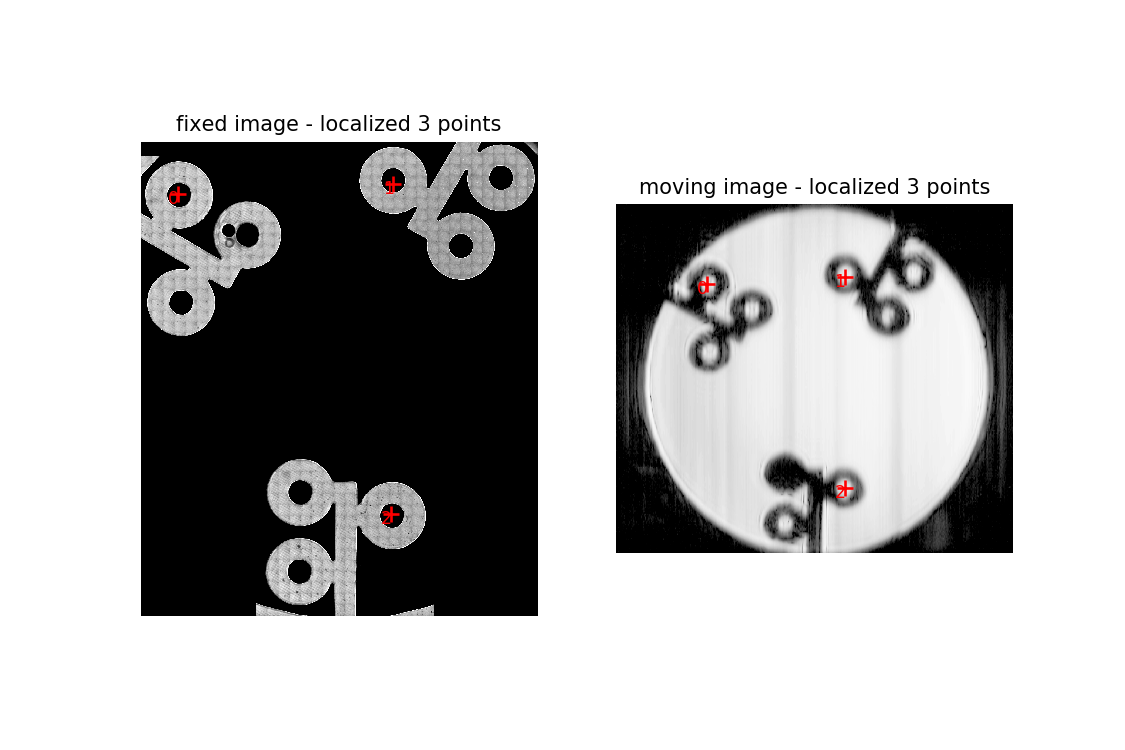

In [14]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_image, height_images[0]))

<IPython.core.display.Javascript object>


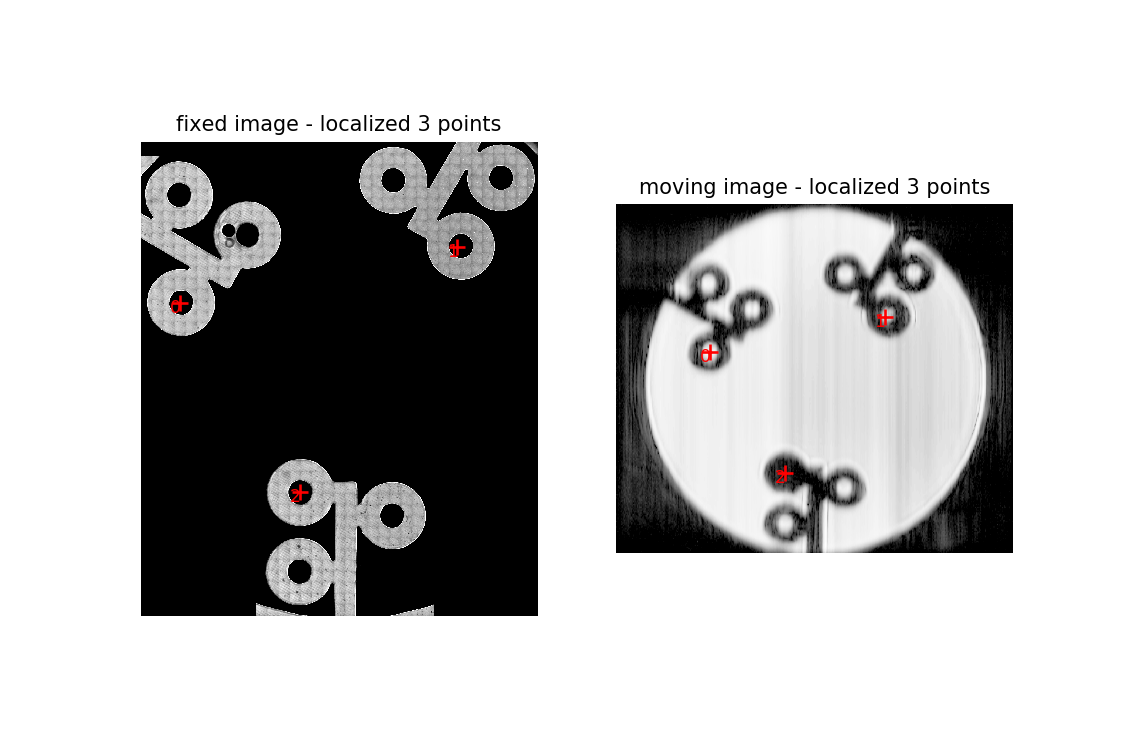

In [15]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_image, height_images[1]))

<IPython.core.display.Javascript object>


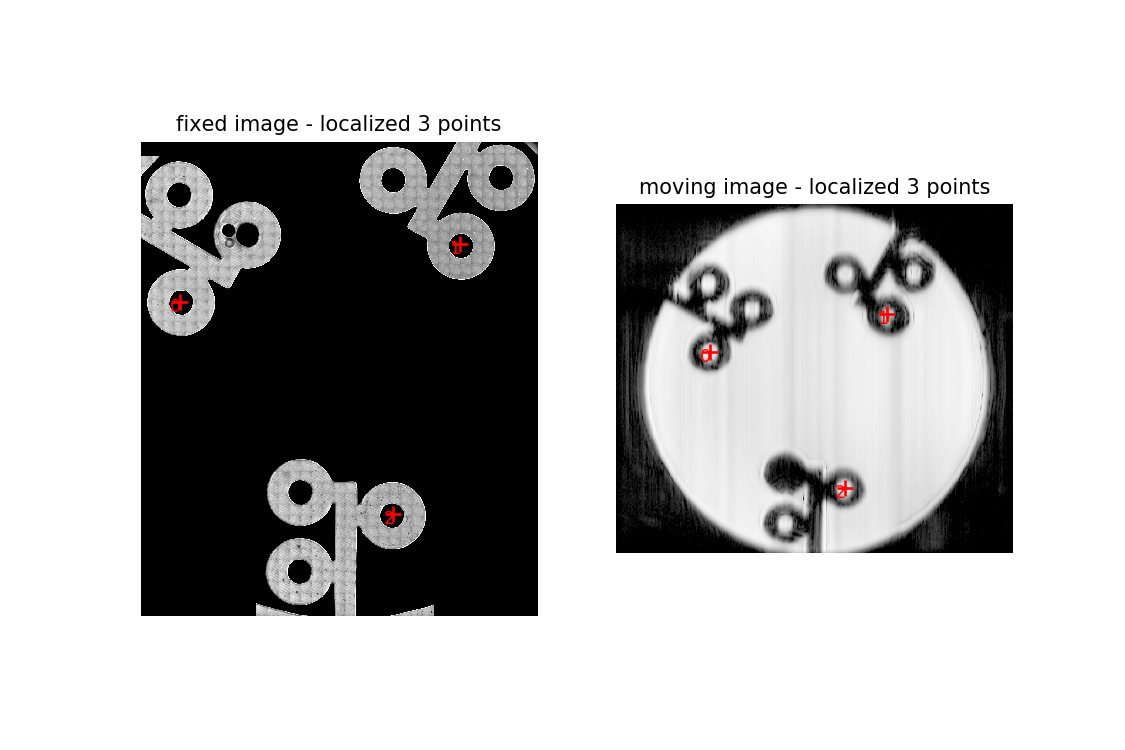

In [16]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_image, height_images[2]))

<IPython.core.display.Javascript object>


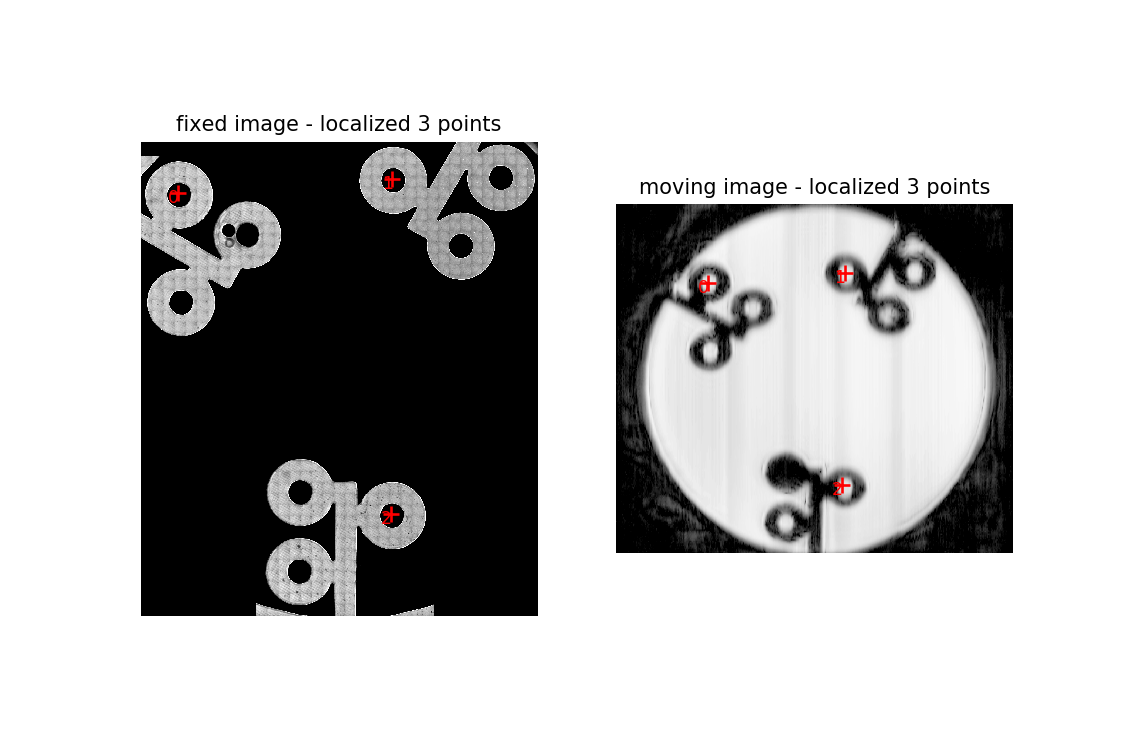

In [17]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_image, height_images[3]))

<IPython.core.display.Javascript object>


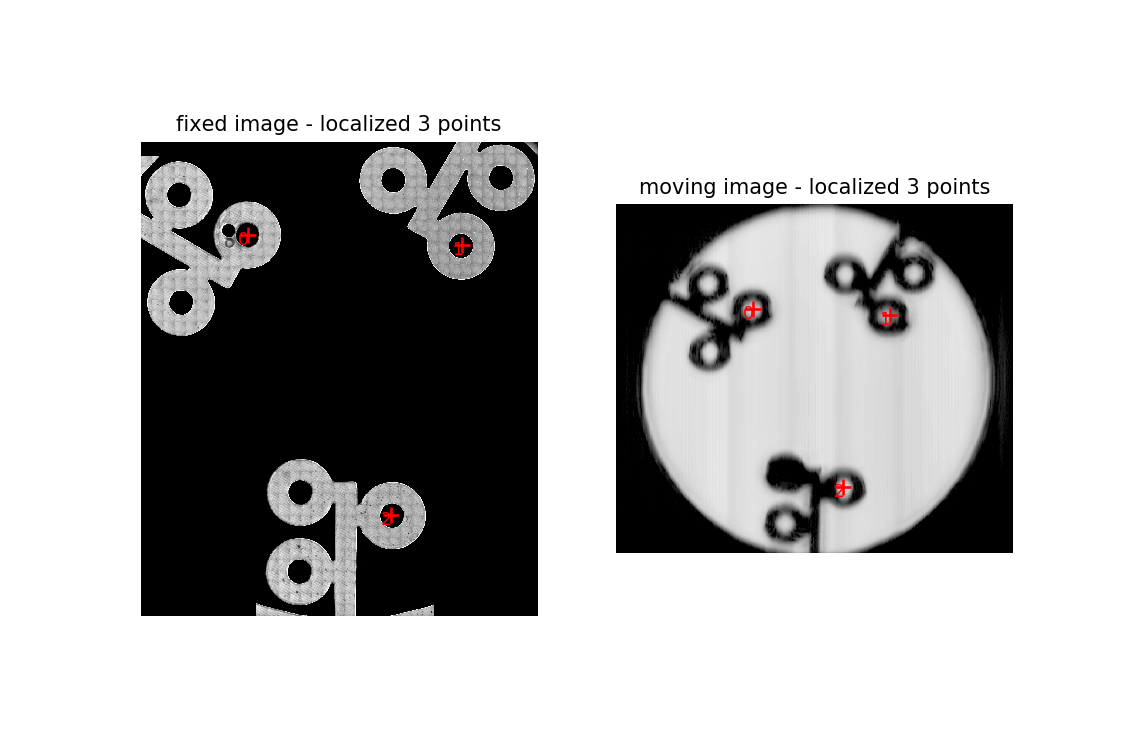

In [18]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_image, height_images[4]))

<IPython.core.display.Javascript object>


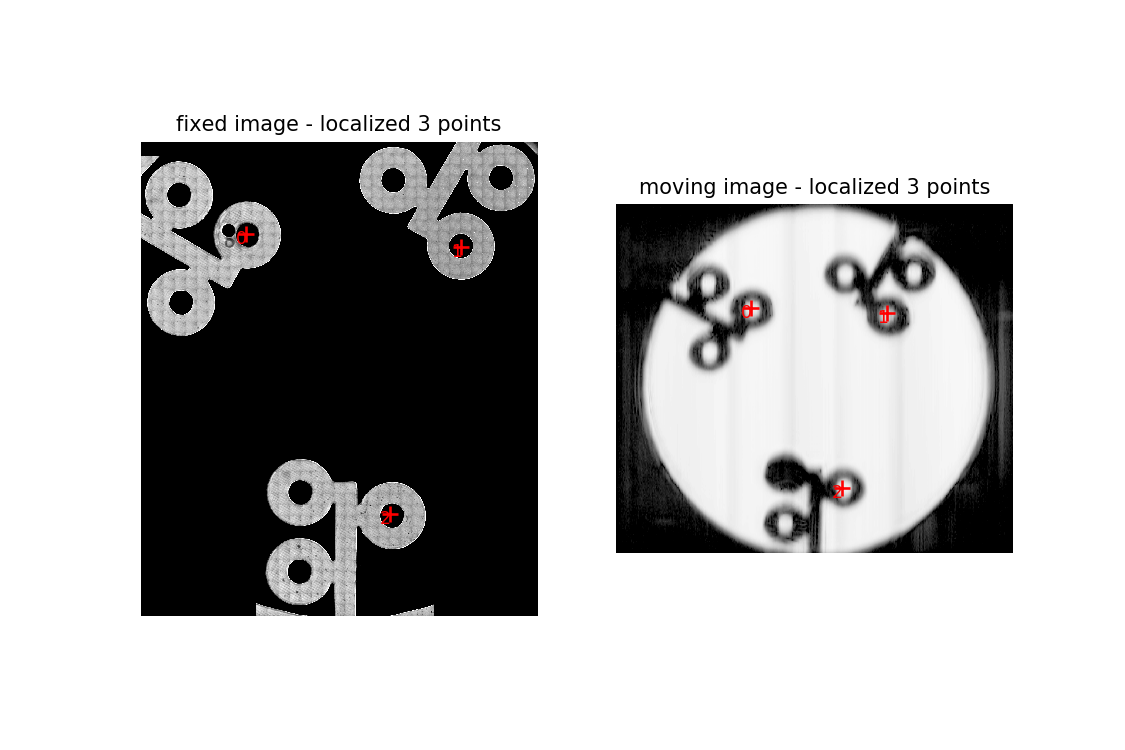

In [19]:
height_points.append(iplt.RegistrationPointDataAcquisition(mpm_image, height_images[5]))

In [20]:
fixed_height_points = []
moving_height_points = []
for idx in range(len(height_points)):
    fixed, moving = height_points[idx].get_points_flat()
    fixed_height_points.append(fixed)
    moving_height_points.append(moving)

In [21]:
fixed_height_path = Path(fiducial_dir, 'Rotation init points - fixed height.txt')
moving_height_path = Path(fiducial_dir, 'Rotation init points - moving height.txt')

In [22]:
# Save marked points or load points previously acquired
if len(fixed_height_points[0]) == 0:
    with open(fixed_height_path, 'rb') as fp:
        fixed_height_points = pickle.load(fp)   
    with open(moving_height_path, 'rb') as fp:
        moving_height_points = pickle.load(fp)
else:
    with open(fixed_height_path, 'wb') as fp:
        pickle.dump(fixed_height_points, fp)
    with open(moving_height_path, 'wb') as fp:
        pickle.dump(moving_height_points, fp)

In [23]:
# Perform the XY registrations
final_height_params = []
metrics_height = []
stops_height = []

In [25]:
for idx in range(len(height_images)):
    initial_transform = sitk.LandmarkBasedTransformInitializer(sitk.VersorRigid3DTransform(), fixed_height_points[idx], moving_height_points[idx])
    final_transform, metric, stop = reg.register(mpm_image, height_images[idx], initial_transform=initial_transform)
    final_height_params.append(final_transform.GetParameters())
    metrics_height.append(metric)
    stops_height.append(stop)
    print('Finished registration {}'.format(idx+1))

Finished registration 1
Finished registration 2
Finished registration 3
Finished registration 4
Finished registration 5
Finished registration 6


In [26]:
# Save or load parameters.
height_params_path = Path(fiducial_dir, 'Height XY parameters.txt')

if len(final_height_params) == 0:
    with open(height_params_path, 'rb') as fp:
        final_height_params = pickle.load(fp)
else:
    with open(height_params_path, 'wb') as fp:
        pickle.dump(final_height_params, fp)

In [27]:
# Load in the parameters calculated for the Zero height image
rotation_params_path = Path(fiducial_dir, 'Rotation XY parameters.txt')
with open(rotation_params_path, 'rb') as fp:
    rotation_params = pickle.load(fp)
zero_params = rotation_params[0]

In [28]:
# Calculate the mean and standard deviation of the XY translation.
height_mean = np.mean(np.array(final_height_params), 0)
height_std = np.std(np.array(final_height_params), 0)
print('X/Y Translation mean: {}'.format(height_mean[3:5]))
print('X/Y Translation std: {}'.format(height_std[3:5]))

X/Y Translation mean: [4542.25764026 1704.15112891]
X/Y Translation std: [20.5764093  22.82135341]


In [29]:
# Show the pattern of differences between the transform mean and the XY translations for each image.
x_diffs = [np.mean(param[3] - zero_params[3]) for param in final_height_params]
y_diffs = [np.mean(param[4] - zero_params[4]) for param in final_height_params]
print('Image name list: {}\n'.format(height_image_names))
print('X translation differences: {}\n'.format(x_diffs))
print('Y translation differences: {}'.format(y_diffs))

Image name list: ['US_H-1000_F-7mm.tif', 'US_H-2000_F-7mm.tif', 'US_H-500_F-7mm.tif', 'US_H1000_F-7mm.tif', 'US_H2000_F-7mm.tif', 'US_H500_F-7mm.tif']

X translation differences: [-41.60011857004156, -42.44626215738481, -42.57241166458971, 15.529522533866839, -34.73972177248834, -30.188188050751705]

Y translation differences: [50.79032648045245, 37.366294777040366, 47.506130290358215, -9.9987920270014, 59.45442347907942, 48.57084226676602]
